# **Stock Price Prediction Model**
COSC 325 Course Project  
Fall 2024
### Members:
  * John Paul Saia  
  * Riley Taylor  
  * Shanna Wallace  

### Objective: 
Create a machine learning model to predict the stock's closing price in 7 days. 

### The Data:
**Data set:** Berkshire Hathaway daily stock price and volume traded from 2015-01-02 to 2024-07-29  
**Format:** .csv file  

#### Target and features:

| Target | Description |
| :- | :- | 
| Close 7 Days | Closing price 7 days from the trading day |

<br>

  | Features | Description |
  | :- | :- | 
  | Date | The day the price data is from (yyyy-mm-dd) |
  | Open | Opening price | 
  | High | Highest price |
  | Low | Lowest price |
  | Close | Closing price |
  | Adj Close | Closing price after adjustments for applicable splits and dividend distributions |
  | Volume | Total number of shares traded that day |

### Feature Selection:
* Calculate correlation coefficients to evaluate correlation between the features, and between the features and the target. 
* Use MDI to compare the importance of the features. 

### The Baseline Model:
* Create and compare 3 regression models using 1 feature:
  * Linear Regression with SKLearn's default class
  * Complex regression model with polynomial expansion.  
  * Linear Regression with gradient descent.  


### The Ensemble Model:
* Use K-Folds Cross Validation to select optimal max depth.
* Use MDI to evaluate relevant importance of all features.


### Model Evaluation and Comparison:
* Calculate R2, MAE, RMSE, and Confidence intervals for both models and compare performance to choose optimal model. 

# Part 1: Prepare and Evaluate Data 

## Load and Clean Data:
* Import all neccessary libraries
* Load csv file of stock data to a DataFrame
* Add column for the target, Close 7 Days, by shifting Close by 7 days
* Convert date to Epoch time
* Remove Adj Close feature
* Clean the data by removing rows with missing values  

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from scipy import stats

In [82]:
RANDOM_STATE = 42
file = "./berkshire_hathaway_data.csv"
stock_data = pd.read_csv(file)

# Ensure the Date column is in datetime format and convert 'Date' to epoch time
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Epoch Time'] = stock_data['Date'].apply(lambda x: int(x.timestamp()))

# Add target: Closing price 7 days later
stock_data['Close 7 Days'] = stock_data['Close'].shift(-7)

# Reorder columns and remove adj close
stock_data = stock_data[['Epoch Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close 7 Days']]

# Drop rows with missing data
stock_data = stock_data.dropna().reset_index(drop=True)


stock_data.head()

,Epoch Time,Open,High,Low,Close,Volume,Close 7 Days
0,1420156800,151.500000,151.600006,148.500000,149.169998,3436400,148.630005
1,1420416000,148.809998,149.000000,146.779999,147.000000,4168800,147.820007
2,1420502400,147.639999,148.529999,146.110001,146.839996,4116100,147.580002
3,1420588800,147.940002,149.139999,147.649994,148.880005,4159100,149.210007
4,1420675200,150.600006,151.369995,150.509995,151.369995,4282100,148.630005


## Visualize Change in Stock Prices and Volume Over Time
Create a line graph of all the price features and target value over time.  
Create a graph of the change in volume over time.    
This will help us visualize relationships between the variables as they change over time, seeing whether they tend to increase and decrease together. 

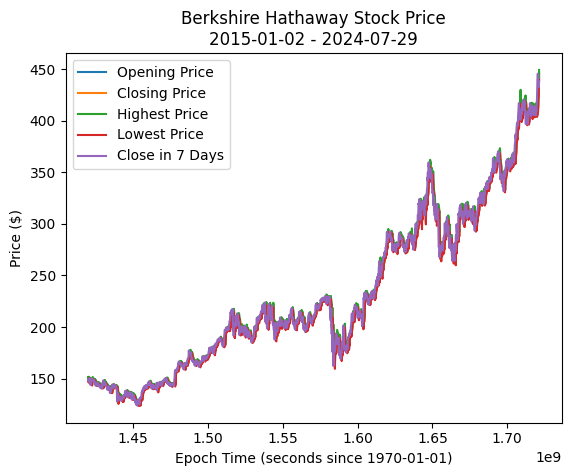

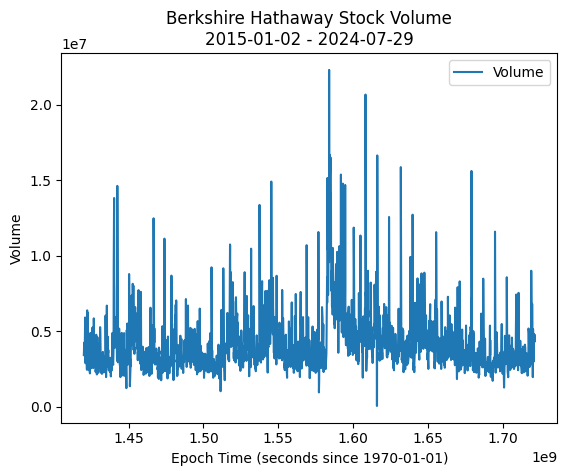

In [3]:
# Plot stock prices with Epoch Time as the x-axis
plt.plot(stock_data['Epoch Time'], stock_data['Open'], label="Opening Price")
plt.plot(stock_data['Epoch Time'], stock_data['Close'], label="Closing Price")
plt.plot(stock_data['Epoch Time'], stock_data['High'], label="Highest Price")
plt.plot(stock_data['Epoch Time'], stock_data['Low'], label="Lowest Price")
plt.plot(stock_data['Epoch Time'], stock_data['Close 7 Days'], label="Close in 7 Days")
plt.title("Berkshire Hathaway Stock Price\n2015-01-02 - 2024-07-29")
plt.xlabel("Epoch Time (seconds since 1970-01-01)")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# Plot stock volume with Epoch Time as the x-axis
plt.plot(stock_data['Epoch Time'], stock_data['Volume'], label="Volume")
plt.title("Berkshire Hathaway Stock Volume\n2015-01-02 - 2024-07-29")
plt.xlabel("Epoch Time (seconds since 1970-01-01)")
plt.ylabel("Volume")
plt.legend()
plt.show()

## Feature Selection:
* Generate scatter plot to visualize relationships between variables
* Generate correlation matrix of correlation coefficients
* Use correlation coefficients of each feature with the target and drop features with correlation value less than 0.5
* Look at the correlation coefficient of the features with the other features and drop ones that are highly correlated with each other

Text(0.5, 1.08, 'Given features')

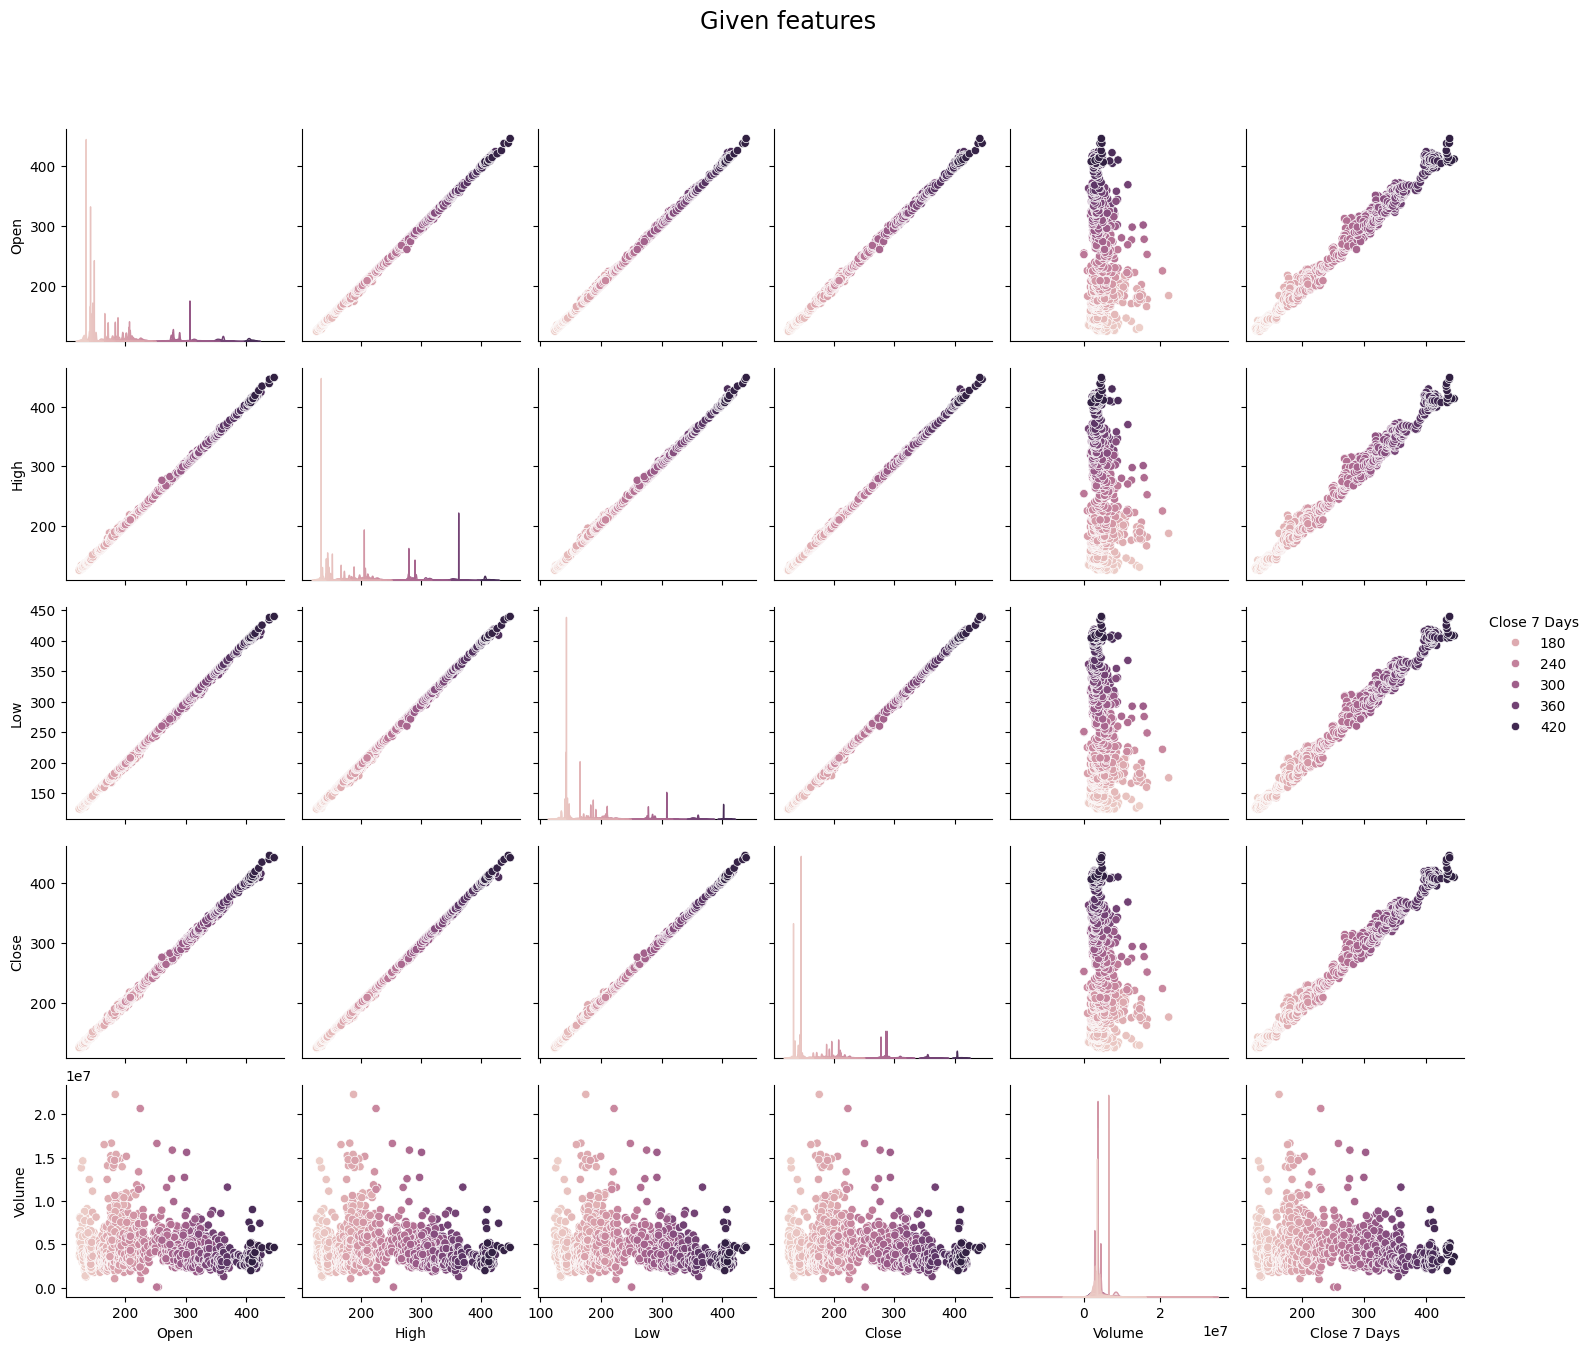

In [4]:
# Display features data trends for the given features with Seaborn pairplot.
given_features = sns.pairplot(stock_data, x_vars=['Open', 'High', 'Low', 'Close', 'Volume', 'Close 7 Days'], 
              y_vars=['Open', 'High', 'Low', 'Close', 'Volume'], hue='Close 7 Days')
given_features.figure.suptitle("Given features", y=1.08, fontsize='xx-large')

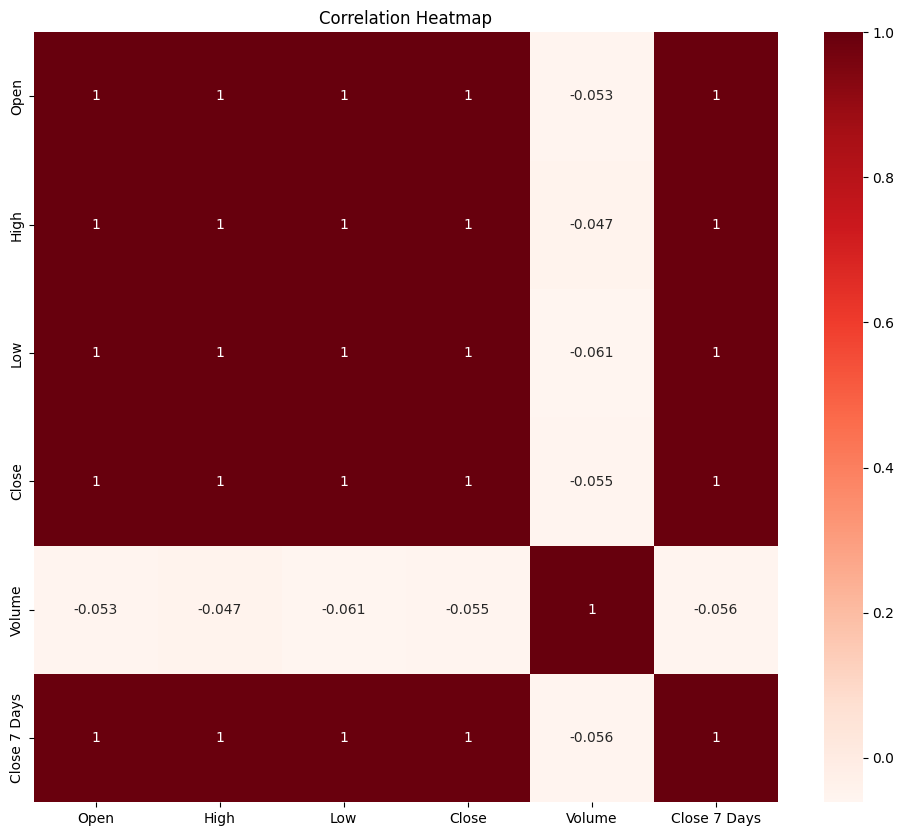

                  Open      High       Low     Close    Volume  Close 7 Days
Open          1.000000  0.999815  0.999776  0.999570 -0.053169      0.995257
High          0.999815  1.000000  0.999725  0.999792 -0.047492      0.995485
Low           0.999776  0.999725  1.000000  0.999799 -0.061293      0.995595
Close         0.999570  0.999792  0.999799  1.000000 -0.055106      0.995708
Volume       -0.053169 -0.047492 -0.061293 -0.055106  1.000000     -0.056169
Close 7 Days  0.995257  0.995485  0.995595  0.995708 -0.056169      1.000000
Highly correlated features with 'Close 7 Days':
Open            0.995257
High            0.995485
Low             0.995595
Close           0.995708
Close 7 Days    1.000000
Name: Close 7 Days, dtype: float64


In [5]:
# Using Pearson Correlation. Remove Epoch Time
plt.figure(figsize=(12, 10))
cor = stock_data.drop(columns="Epoch Time").corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title("Correlation Heatmap")
plt.show()

# Display correlation matrix
print(cor)

# Correlation with the target variable
cor_target = abs(cor["Close 7 Days"])

# Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.75]
print("Highly correlated features with 'Close 7 Days':")
print(relevant_features)

### Extract Features and Create Training and Test Sets
* Extract target and selected features
    * X_simple: Only keep one relevant feature for the simple model
    * X_complex: Keep all features for the ensemble model
    * y: the target, Close 7 Days
* Split data in to training and testing sets
    * Training 80% / Testing 20%
    * Since chronological, want future dates in testing data and past dates in training data to avoid data leaks

In [6]:
# Extract target and features
# # Target: Closing price in 7 days
y = stock_data['Close 7 Days']

# Keep one feature for the simple linear regression model. 
simple_feature_list = ["Close"]
X_simple = stock_data[simple_feature_list]

# Keep all price and volume features for the ensemble model
complex_feature_list = ['Open', 'High', 'Low', 'Close', 'Volume']
X_complex = stock_data[complex_feature_list]



# Create training and test sets
# Define the proportion of data for training, 80% for training, 20% for testing
train_ratio = 0.8  

# Split data into training and testing sets
train_size = int(len(stock_data) * train_ratio)

# Target values
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# Simple training and testing feature sets
X_train_simple = X_simple.iloc[:train_size]
X_test_simple = X_simple.iloc[train_size:]

# Complex training and testing feature sets
X_train_complex = X_complex.iloc[:train_size]
X_test_complex = X_complex.iloc[train_size:]

# Print selected features and set sizes
print(f"Simple training set (X_train_simple) size: {X_train_simple.shape[0]}\nSimple testing set (X_test_simple) size:   {X_test_simple.shape[0]}\n")
print(f"Complex training set (X_train_complex) size: {X_train_complex.shape[0]}\nComplex testing set (X_test_complex) size:   {X_test_complex.shape[0]}\n")
print(f"Training output set (y_train) size: {y_train.shape[0]}\nTesting output set (y_test) size:   {y_test.shape[0]}")


Simple training set (X_train_simple) size: 1920
Simple testing set (X_test_simple) size:   481

Complex training set (X_train_complex) size: 1920
Complex testing set (X_test_complex) size:   481

Training output set (y_train) size: 1920
Testing output set (y_test) size:   481


# Part 2: Simple Linear Regression Model
### Create and Fit Linear Model using sklearn's default, Ordinary Least Squares

In [7]:
# Create the simple Model and train it
simple_model = LinearRegression()
simple_model.fit(X_train_simple, y_train)


LinearRegression()

## Get Predictions and Analyze Performance
* Plot the model
* Calculate performance metrics:
    * Bias
    * Variance
    * RMSE (Root Mean Squared Error)
    * MAE (Mean Absolue Error)
    * Confidence Interval
* Graph the regression line

In [8]:
# simple_pred = simple_model.predict(simple_X_test)
simple_pred = pd.Series(simple_model.predict(X_test_simple), index=X_test_simple.index)

# Calculate the mean of the predictions (expected prediction)
simple_mean_pred = np.mean(simple_pred)

# Calculate bias, variance, and Root Mean Squared Error (RMSE) on the test set
simple_rmse = root_mean_squared_error(y_test, simple_pred)
simple_r2 = r2_score(y_test, simple_pred)
simple_mae = mean_absolute_error(y_test, simple_pred)

print(f"Simple Model Results:\n  R2: {simple_r2:.5}\n  RMSE: ${simple_rmse:,.5}\n  MAE: ${simple_mae:,.5}")

Simple Model Results:
  R2: 0.958
  RMSE: $9.1153
  MAE: $7.3144


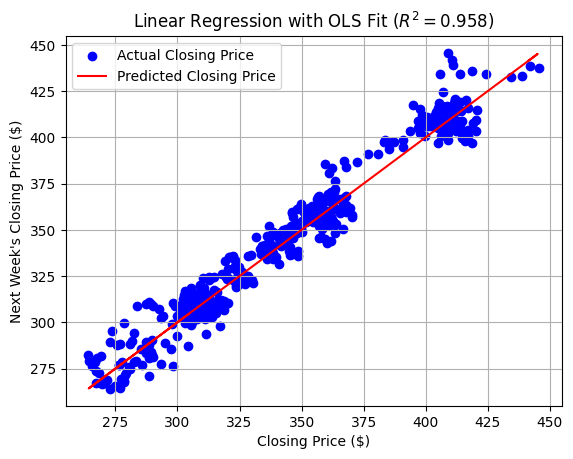

In [9]:
plt.scatter(X_test_simple, y_test, label='Actual Closing Price', color='blue')
plt.plot(simple_pred, simple_pred, label='Predicted Closing Price', color='red')
plt.title(f"Closing Price vs. Next Week's Closing Price (Simple Linear Model)")
plt.title(f"Linear Regression with OLS Fit ($R^2=${simple_r2:.3f})")
plt.xlabel(f"Closing Price ($)")
plt.ylabel("Next Week's Closing Price ($)")
plt.legend()
plt.grid(True)

# Part 3: Create Ensemble Random Forest Model 
## Use K-Folds Cross Validation to choose optimal max depth for the trees
* Test depths 1 through 10
* Compute confidence intervals and accuracy for each depth 
* Create plot of accuracy vs depth to visualize and help select best depth

In [10]:
from sklearn.model_selection import KFold

def k_fold_cv(X, y, k, model):
    # Initialization:
    kf = KFold(n_splits=k, random_state=RANDOM_STATE, shuffle=True) # Initialize kfolds splitter
    cv_scores = [] # Initialize a placeholder for cv scores
    
    for train_indices, val_indices in kf.split(X):


        # Create training and validation folds:
        if hasattr(X, "iloc") & hasattr(y, "iloc") : # If X, y are dataframes
            X_train_fold, y_train_fold = X.iloc[train_indices], y.iloc[train_indices] # Obtain features and labels of samples in training fold of current iteration
            X_val_fold, y_val_fold = X.iloc[val_indices], y.iloc[val_indices] # Obtain features and labels of samples in validation fold of current iteration
        else: # If X is a numpy array
            X_train_fold, y_train_fold = X[train_indices], y[train_indices] # Obtain features and labels of samples in training fold of current iteration
            X_val_fold, y_val_fold = X[val_indices], y[val_indices] # Obtain features and labels of samples in validation fold of current iteration

        # Fit the model with training folds data
        model.fit(X_train_fold, y_train_fold)

        # Validate the model and compute validation score with validation folds data
        cv_scores.append(model.score(X_val_fold, y_val_fold))

    cv_scores = np.array(cv_scores) # Convert to numpy
    return cv_scores, np.mean(cv_scores), np.std(cv_scores)

In [11]:
# Initializations:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # Hyperparameter space for the tree: deeper the max_depth, higher the capacity
train_scores = [] # List to store the training set scores (should be a length of `depths`, i.e. the number of experiments)
cv_means = [] # List to store the cross-validation scores (should be a length of `depths`, i.e. the number of experiments)
cv_stds = [] # List to store the cross-validation scores (should be a length of `depths`, i.e. the number of experiments)

for d in depths:

    # Construct the model of the "d" of current iteration
    complex_model = RandomForestRegressor(max_depth=d, random_state=RANDOM_STATE) 

    # Fit model with training data and add its accuracy to list
    complex_model.fit(X_train_complex, y_train) 
    train_scores.append(complex_model.score(X_train_complex, y_train))  

    # Perform KFold CV and add mean CV score and standard deviation to list
    _, mean, std = k_fold_cv(X_train_complex, y_train, 10, complex_model) 
    cv_means.append(mean)          
    cv_stds.append(std)           

# Convert lists to numpy arrays
cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

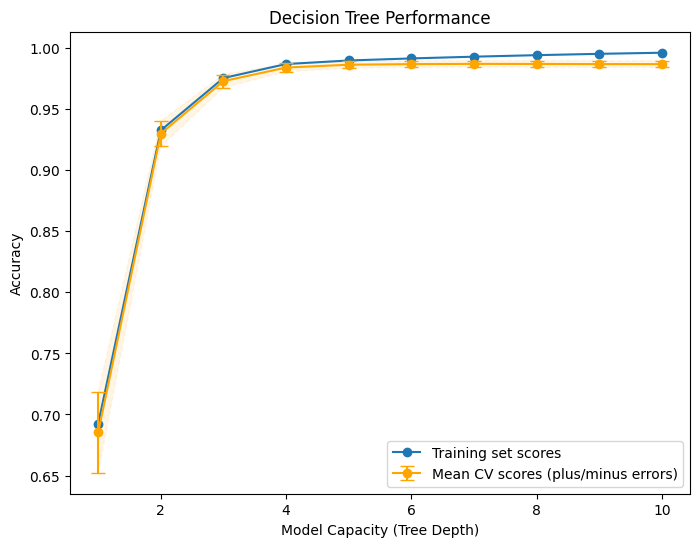

Depth with best CV score 7


In [12]:
# Create the plot
plt.figure(figsize = (8, 6))

# Plot the line with error bars (standard deviation)
plt.plot(depths, train_scores, label = "Training set scores", marker = "o")
plt.errorbar(depths, cv_means, yerr = cv_stds, fmt = "-o", capsize = 5, label = "Mean CV scores (plus/minus errors)", color = "orange")
plt.fill_between(depths, 
                 cv_means + cv_stds, 
                 cv_means - cv_stds, 
                 linestyle = "--",
                 alpha = 0.1, color = "orange")

# Add labels and title
plt.xlabel("Model Capacity (Tree Depth)")
plt.ylabel("Accuracy")
plt.title("Decision Tree Performance")
# Display legend
plt.legend()
# Show the plot
plt.show()
# Best depth
best_depth = depths[np.argmax(cv_means)]
print(f"Depth with best CV score {best_depth}")

## Create Random Forest with the optimal depth
* Create model using depth of 4 based on above testing
* Use complex feature training and testing sets
* Calculate performance metrics:
    * R2
    * RMSE
    * MAE
    * Confidence intervals
* Visualize the first 3 trees from the forest

In [13]:
complex_model = RandomForestRegressor(max_depth=6, random_state=RANDOM_STATE) 
complex_model.fit(X_train_complex.values, y_train) 
complex_pred = complex_model.predict(X_test_complex.values).reshape(-1, 1)

complex_r2 = complex_model.score(X_train_complex.values, y_train)
complex_rmse = root_mean_squared_error(y_test, complex_pred)
complex_mae = mean_absolute_error(y_test, complex_pred)

# Calculate the standard error of the predictions
forest_se = np.sqrt(np.sum((y_test - complex_pred.flatten()) ** 2) / (len(y_test) - 2))

# Calculate the confidence intervals
confidence_interval_forest = stats.t.interval(0.95, len(y_test) - 1, loc=np.mean(complex_pred), scale=forest_se)

print(f"Ensemble Model Results:")
print(f"  R2: {complex_r2:.4f}")
print(f"  RMSE: ${complex_rmse:.4f}")
print(f"  MAE: ${complex_mae:.4f}")
print(f"  Confidence interval: [{confidence_interval_forest[0]}, {confidence_interval_forest[1]}]")



Ensemble Model Results:
  R2: 0.9915
  RMSE: $38.8131
  MAE: $29.2511
  Confidence interval: [245.01220845378515, 397.8595022075486]


## Feature Selection with MDI

mean: [np.float64(0.07062778451710292), np.float64(0.23903118928857478), np.float64(0.06204535073317845), np.float64(0.6260699991699582), np.float64(0.0022256762911857693)]
std dev: [np.float64(0.19807970316952409), np.float64(0.23457529646453218), np.float64(0.13900992854001715), np.float64(0.3104460693994757), np.float64(0.0006069762466714428)]
forest importances: [0.07062778 0.23903119 0.06204535 0.62607    0.00222568]


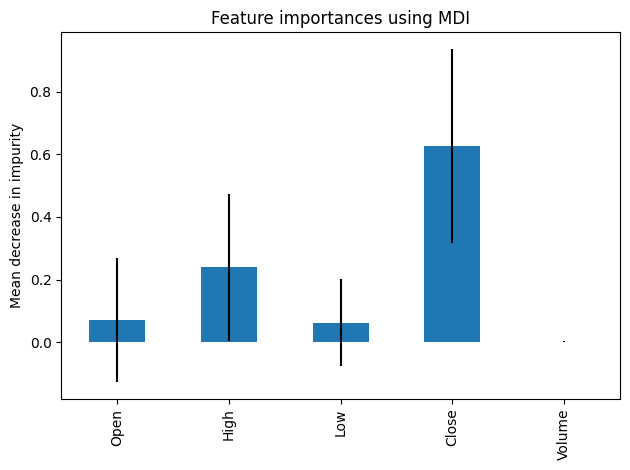

In [14]:
trees_importances = np.array([tree.feature_importances_ for tree in complex_model.estimators_])

# feature importances measures from the forest
forest_importances = complex_model.feature_importances_

# Compute mean feature importances for each feature
mean_importances = [column.mean() for column in trees_importances.T]
# Compute standard deviation feature importances for each feature
std_importances = [column.std() for column in trees_importances.T]

print(f"mean: {mean_importances}\nstd dev: {std_importances}\nforest importances: {forest_importances}")


forest_importances = pd.Series(forest_importances, index = complex_feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = std_importances, ax = ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


## Create Random Forest with only Best Features
* Based on MDI, Close feature is the most important
* Create random feature only using Close

In [151]:
complex_model = RandomForestRegressor(max_depth=6, random_state=RANDOM_STATE) 
complex_model.fit(X_train_simple.values, y_train) 
complex_pred = complex_model.predict(X_test_simple.values)

complex_r2 = complex_model.score(X_train_simple.values, y_train)
complex_rmse = root_mean_squared_error(y_test, complex_pred)
complex_mae = mean_absolute_error(y_test, complex_pred)

# Calculate the standard error of the predictions
forest_se = np.sqrt(np.sum((y_test - complex_pred) ** 2) / (len(y_test) - 2))

# Calculate the confidence intervals
confidence_interval_forest = stats.t.interval(0.95, len(y_test) - 1, loc=np.mean(complex_pred), scale=forest_se)

print(f"Ensemble Model Results:")
print(f"  R2: {complex_r2:.4f}")
print(f"  RMSE: ${complex_rmse:.4f}")
print(f"  MAE: ${complex_mae:.4f}")
print(f"  Confidence interval: [{confidence_interval_forest[0]}, {confidence_interval_forest[1]}]")

Ensemble Model Results:
  R2: 0.9886
  RMSE: $34.1382
  MAE: $23.3328
  Confidence interval: [260.6037006527218, 395.0409776716837]


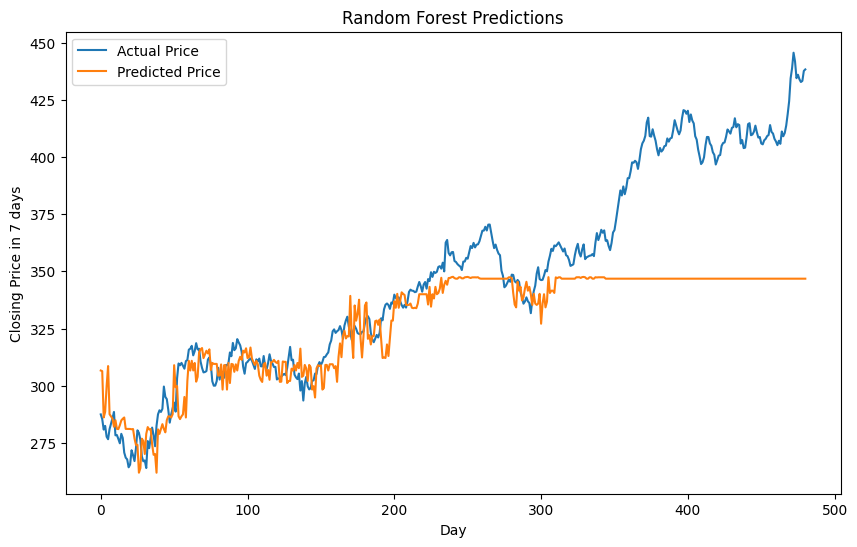

In [152]:
# Plot Confidence Intervals
days = np.arange(y_test.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(days, y_test, label='Actual Price')
plt.plot(days, complex_pred, label='Predicted Price')
plt.xlabel('Day')
plt.ylabel('Closing Price in 7 days')
plt.title('Random Forest Predictions')
plt.legend()
plt.show()


## Create Random Forest only with Values Under Threshold
* Since our model can't predict values outside of the range in the training set, limit values in the test set to those below the maximum value in the training set.
* Comparing this with our unfiltered results will help us see how much unseen data points that are out of range are affecting our model's performance.

In [159]:
filtered_complex_model = RandomForestRegressor(max_depth=6, random_state=RANDOM_STATE) 

threshold = X_train_simple.values.max()
print(f"Maximum training value = ${threshold}")

filtered_df = pd.DataFrame(X_test_simple)
filtered_df["y"] = y_test

filtered_df = filtered_df[filtered_df["Close"] <=threshold]
X_test_filtered = np.array(filtered_df["Close"]).reshape(-1, 1)
y_test_filtered = filtered_df["y"]

filtered_complex_model.fit(X_train_simple.values, y_train) 
filtered_complex_pred = filtered_complex_model.predict(X_test_filtered)

filtered_complex_r2 = filtered_complex_model.score(X_train_simple.values, y_train)
filtered_complex_rmse = root_mean_squared_error(y_test_filtered, filtered_complex_pred)
filtered_complex_mae = mean_absolute_error(y_test_filtered, filtered_complex_pred)

# Calculate the standard error of the predictions
filtered_forest_se = np.sqrt(np.sum((y_test_filtered - filtered_complex_pred) ** 2) / (len(y_test_filtered) - 2))

# Calculate the confidence intervals
filtered_confidence_interval_forest = stats.t.interval(0.95, len(y_test_filtered) - 1, loc=np.mean(filtered_complex_pred), scale=filtered_forest_se)

print(f"Ensemble Model Results:")
print(f"  R2: {filtered_complex_r2:.4f}")
print(f"  RMSE: ${filtered_complex_rmse:.4f}")
print(f"  MAE: ${filtered_complex_mae:.4f}")
print(f"  Confidence interval: [{filtered_confidence_interval_forest[0]}, {filtered_confidence_interval_forest[1]}]")


Maximum training value = $359.57000732421875
Ensemble Model Results:
  R2: 0.9886
  RMSE: $10.5194
  MAE: $8.6036
  Confidence interval: [296.8732326921071, 338.40185662909323]


## Plot the Model Results

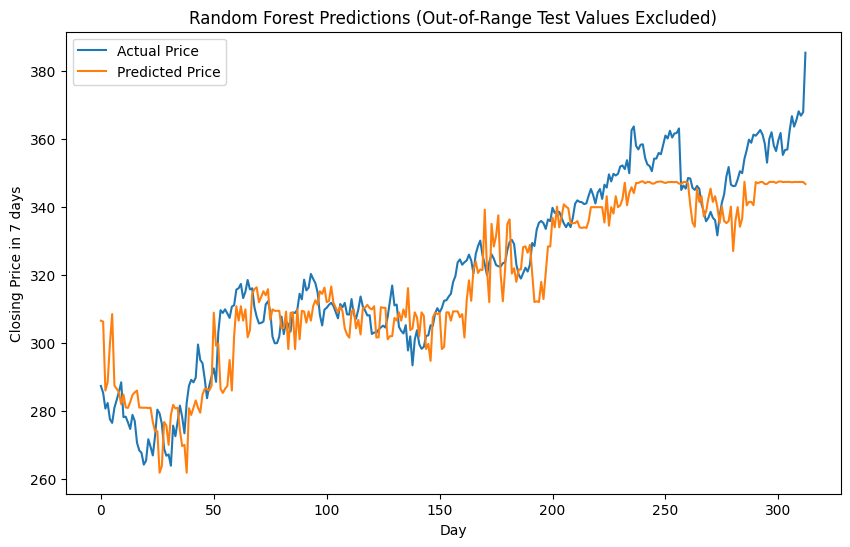

In [156]:
# Plot Confidence Intervals
days = np.arange(y_test_filtered.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(days, y_test_filtered, label='Actual Price')
plt.plot(days, filtered_complex_pred, label='Predicted Price')
plt.xlabel('Day')
plt.ylabel('Closing Price in 7 days')
plt.title('Random Forest Predictions (Out-of-Range Test Values Excluded)')
plt.legend()
plt.show()



# Part 4: Compare model performance and Analyze Results
Our simple linear regression model shows superior performance compared to our ensemble random forest method, with the lowest average error. <br>
 
This is unsurprising since our features had such a strong linear relationship with each other, as well as with the target. A linear model is the most appropriate choice for this type of data. <Br>

Since our data is chronological, it was split so that data points in the test set are from dates later than data points in the training set. This can lead to poor performance with a random forest if the later dates happen to contain closing prices higher than any date in the training set, since the random forest model's prediction is limited to values it saw in the training data. <br>

Unfortunately, this was the case with our data set. When dates that contain prices higher than the maximum price in the training set are filtered out of the testing data, model performance improves significantly. This demonstrates how negatively our random forest model's accuracy is impacted when it encounteres unseen data values that are outside the range of data points it saw in the training data. 

In [158]:
print(f"Simple Model Results:\n  R2: {simple_r2:.5}\n  RMSE: ${simple_rmse:,.5}\n  MAE: ${simple_mae:,.5}")
# print(f"  Confidence interval: [{}, {}]\n")

print(f"\nUnfiltered Ensemble Model Results:")
print(f"  R2: {complex_r2:.4f}")
print(f"  RMSE: ${complex_rmse:.4f}")
print(f"  MAE: ${complex_mae:.4f}")
print(f"  Confidence interval: [{confidence_interval_forest[0]}, {confidence_interval_forest[1]}]")

print(f"\nFiltered Ensemble Model Results:")
print(f"  R2: {filtered_complex_r2:.4f}")
print(f"  RMSE: ${filtered_complex_rmse:.4f}")
print(f"  MAE: ${filtered_complex_mae:.4f}")
print(f"  Confidence interval: [{filtered_confidence_interval_forest[0]}, {filtered_confidence_interval_forest[1]}]")


Simple Model Results:
  R2: 0.958
  RMSE: $9.1153
  MAE: $7.3144

Unfiltered Ensemble Model Results:
  R2: 0.9886
  RMSE: $34.1382
  MAE: $23.3328
  Confidence interval: [260.6037006527218, 395.0409776716837]

Filtered Ensemble Model Results:
  R2: 0.9886
  RMSE: $10.5194
  MAE: $8.6036
  Confidence interval: [296.8732326921071, 338.40185662909323]
